<a href="https://colab.research.google.com/github/yblee110/jax-flax-book/blob/main/ch04_3_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
import jax
import flax
import optax


print("JAX Version : {}".format(jax.__version__))
print("FLAX Version : {}".format(flax.__version__))
print("OPTAX Version : {}".format(optax.__version__))


JAX Version : 0.4.26
FLAX Version : 0.8.4
OPTAX Version : 0.2.2


In [3]:
batch_size = 2048
z_dim = 64
seed = 0

In [4]:
import jax.numpy as jnp
from datasets import load_dataset


def get_datasets():
    datasets = load_dataset("mnist")
    datasets = datasets.with_format("jax")
    datasets = {
        "train": {
            "image": (datasets["train"]["image"][...,None].astype(jnp.float32)/255 - 0.5) / 0.5,
            "label": datasets["train"]["label"],
        }
    }
    return datasets['train']


In [5]:
train_ds = get_datasets()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
from functools import partial
from typing import Any, Callable, Sequence, Tuple


from jax.nn.initializers import normal as normal_init
from flax import linen as nn
import jax.numpy as jnp


ModuleDef = Any


In [7]:
class Generator(nn.Module):
    features: int = z_dim
    dtype: type = jnp.float32


    @nn.compact
    def __call__(self, z: jnp.ndarray, train: bool = True):
        conv_transpose = partial(nn.ConvTranspose, padding='VALID',
                                kernel_init=normal_init(0.02), dtype=self.dtype)
        batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                            scale_init=normal_init(0.02), dtype=self.dtype)


        z = z.reshape((batch_size, 1, 1, z_dim))
        x = conv_transpose(self.features*4, kernel_size=[3, 3], strides=[2, 2])(z)
        x = batch_norm()(x)
        x = nn.relu(x)
        x = conv_transpose(self.features*4, kernel_size=[4, 4], strides=[1, 1])(x)
        x = batch_norm()(x)
        x = nn.relu(x)
        x = conv_transpose(self.features*2, kernel_size=[3, 3], strides=[2, 2])(x)
        x = batch_norm()(x)
        x = nn.relu(x)
        x = conv_transpose(1, [4, 4], [2, 2])(x)
        x = jnp.tanh(x)
        return x

In [8]:
class Discriminator(nn.Module):
    features: int = z_dim
    dtype: Any = jnp.float32


    @nn.compact
    def __call__(self, x: jnp.ndarray, train: bool = True):
        conv = partial(nn.Conv, kernel_size=[4, 4], strides=[2, 2], padding='VALID',
                    kernel_init=normal_init(0.02), dtype=self.dtype)
        batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                            scale_init=normal_init(0.02), dtype=self.dtype)


        x = conv(self.features)(x)
        x = batch_norm()(x)
        x = nn.leaky_relu(x, 0.2)
        x = conv(self.features*2)(x)
        x = batch_norm()(x)
        x = nn.leaky_relu(x, 0.2)
        x = conv(1)(x)
        x = x.reshape((batch_size, -1))
        return x


In [9]:
def generator_step(generator_state, discriminator_state, key):
    input_noise = jax.random.normal(key, (batch_size, z_dim))


    def loss_fn(params):
        generated_data, mutables = generator_state.apply_fn(
            {'params': params, 'batch_stats': generator_state.batch_stats},
            input_noise, mutable=['batch_stats'])


        logits, _ = discriminator_state.apply_fn(
                {'params': discriminator_state.params,
                'batch_stats': discriminator_state.batch_stats},
                generated_data, mutable=['batch_stats'])


        loss = -jnp.mean(jnp.log(nn.sigmoid(logits)))


        return loss, mutables


    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(generator_state.params)


    generator_state = generator_state.apply_gradients(
        grads=grads, batch_stats=updates['batch_stats'])


    return generator_state, loss

In [10]:
def discriminator_step(generator_state, discriminator_state, batch, key):
    input_noise = jax.random.normal(key, (batch_size, z_dim))


    generated_data, _ = generator_state.apply_fn(
        {'params': generator_state.params, 'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])


    def loss_fn(params):
        logits_real, mutables = discriminator_state.apply_fn(
            {'params': params, 'batch_stats': discriminator_state.batch_stats},
            batch, mutable=['batch_stats'])


        logits_generated, mutables = discriminator_state.apply_fn(
            {'params': params, 'batch_stats': mutables['batch_stats']},
            generated_data, mutable=['batch_stats'])


        real_loss = optax.sigmoid_binary_cross_entropy(
            logits_real, jnp.ones((batch_size, 1), dtype=jnp.int32)).mean()
        generated_loss = optax.sigmoid_binary_cross_entropy(
            logits_generated, jnp.zeros((batch_size, 1), dtype=jnp.int32)).mean()


        loss = (real_loss + generated_loss) / 2


        return loss, mutables


    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(discriminator_state.params)


    discriminator_state = discriminator_state.apply_gradients(
        grads=grads, batch_stats=updates['batch_stats'])


    return discriminator_state, loss


In [11]:
from flax.training import train_state


class TrainState(train_state.TrainState):
    batch_stats: Any


def create_state(rng, model_cls, input_shape):
    model = model_cls()


    b1 = 0.5
    b2 = 0.999
    learning_rate = 0.002
    tx = optax.adam(learning_rate=learning_rate, b1=b1, b2=b2)


    variables = model.init(rng, input_shape)


    state = TrainState.create(
        apply_fn=model.apply,
        params=variables['params'],
        batch_stats=variables['batch_stats'],
        tx=tx
    )


    return state


def generate_sample(generator_state, input_noise):
    generated_data = generator_state.apply_fn(
        {'params': generator_state.params,
         'batch_stats': generator_state.batch_stats},
        input_noise, train=False, mutable=False
    )


    return generated_data


rng = jax.random.PRNGKey(0)
key_generator, key_discriminator, key = jax.random.split(rng, 3)


discriminator_state = create_state(key_discriminator, Discriminator, jnp.ones((batch_size, 28, 28, 1)))
generator_state = create_state(key_generator, Generator, jnp.ones((batch_size, z_dim)))


generator_input = jax.random.normal(key, (batch_size, z_dim))


In [12]:
from tqdm.notebook import tqdm


def train_loop(generator_state, discriminator_state, train_ds, batch_size, epoch, key):
    train_ds_size = train_ds['image'].shape[0]
    steps_per_epoch = train_ds_size // batch_size


    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))


    batch_metrics = {
        'generator_loss' : [],
        'discriminator_loss' : []
        }


    with tqdm(total=steps_per_epoch, desc="Training...",
                leave=False) as progress_bar_train:


        for perm in perms:
            # generator와 discriminator를 위한 RNG 키를 생성합니다.
            key, key_generator, key_discriminator = jax.random.split(key, 3)


            batch_data = train_ds['image'][perm, ...]


            # generator step.
            generator_state, generator_loss = generator_step(generator_state,
                discriminator_state, key_generator)


            # discriminator .
            discriminator_state, discriminator_loss = discriminator_step(
                generator_state, discriminator_state, batch_data, key_discriminator)


            batch_metrics['generator_loss'].append(generator_loss)
            batch_metrics['discriminator_loss'].append(discriminator_loss)


            progress_bar_train.update(1)


        message = f"Epoch: {epoch: <2} | "
        message += f"Generator loss: {sum(batch_metrics['generator_loss']) / len(batch_metrics['generator_loss']):.3f} | "
        message += f"Discriminator loss: {sum(batch_metrics['discriminator_loss']) / len(batch_metrics['discriminator_loss']):.3f}"


        progress_bar_train.write(message)


    return generator_state, discriminator_state


train_epoch = 100


for epoch in tqdm(range(1, train_epoch + 1), desc="Epoch...",
                  position=0, leave=True):
    generator_state, discriminator_state = train_loop(generator_state, discriminator_state, train_ds, batch_size, epoch, key)


Epoch...:   0%|          | 0/100 [00:00<?, ?it/s]

Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1  | Generator loss: 0.819 | Discriminator loss: 0.583


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 2  | Generator loss: 1.362 | Discriminator loss: 0.558


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 3  | Generator loss: 1.936 | Discriminator loss: 0.494


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 4  | Generator loss: 1.719 | Discriminator loss: 0.519


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 5  | Generator loss: 1.778 | Discriminator loss: 0.553


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 6  | Generator loss: 1.564 | Discriminator loss: 0.529


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 7  | Generator loss: 1.773 | Discriminator loss: 0.536


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 8  | Generator loss: 1.530 | Discriminator loss: 0.511


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 9  | Generator loss: 1.653 | Discriminator loss: 0.474


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 10 | Generator loss: 1.608 | Discriminator loss: 0.501


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 11 | Generator loss: 1.871 | Discriminator loss: 0.547


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 12 | Generator loss: 1.590 | Discriminator loss: 0.486


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 13 | Generator loss: 1.713 | Discriminator loss: 0.469


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 14 | Generator loss: 1.858 | Discriminator loss: 0.477


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 15 | Generator loss: 1.640 | Discriminator loss: 0.497


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 16 | Generator loss: 1.627 | Discriminator loss: 0.554


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 17 | Generator loss: 1.623 | Discriminator loss: 0.482


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 18 | Generator loss: 1.502 | Discriminator loss: 0.495


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 19 | Generator loss: 1.511 | Discriminator loss: 0.521


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 20 | Generator loss: 1.469 | Discriminator loss: 0.574


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 21 | Generator loss: 1.360 | Discriminator loss: 0.585


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 22 | Generator loss: 1.365 | Discriminator loss: 0.550


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 23 | Generator loss: 1.318 | Discriminator loss: 0.665


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 24 | Generator loss: 1.088 | Discriminator loss: 0.620


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 25 | Generator loss: 1.212 | Discriminator loss: 0.587


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 26 | Generator loss: 1.128 | Discriminator loss: 0.560


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 27 | Generator loss: 1.083 | Discriminator loss: 0.575


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 28 | Generator loss: 1.128 | Discriminator loss: 0.568


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 29 | Generator loss: 1.066 | Discriminator loss: 0.617


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 30 | Generator loss: 1.008 | Discriminator loss: 0.700


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 31 | Generator loss: 1.115 | Discriminator loss: 0.611


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 32 | Generator loss: 1.075 | Discriminator loss: 0.578


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 33 | Generator loss: 1.032 | Discriminator loss: 0.599


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 34 | Generator loss: 0.997 | Discriminator loss: 0.628


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 35 | Generator loss: 0.982 | Discriminator loss: 0.607


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 36 | Generator loss: 1.009 | Discriminator loss: 0.593


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 37 | Generator loss: 0.973 | Discriminator loss: 0.703


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 38 | Generator loss: 1.020 | Discriminator loss: 0.679


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 39 | Generator loss: 0.960 | Discriminator loss: 0.606


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 40 | Generator loss: 0.929 | Discriminator loss: 0.591


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 41 | Generator loss: 0.893 | Discriminator loss: 0.623


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 42 | Generator loss: 0.939 | Discriminator loss: 0.591


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 43 | Generator loss: 0.939 | Discriminator loss: 0.597


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 44 | Generator loss: 0.927 | Discriminator loss: 0.715


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 45 | Generator loss: 0.887 | Discriminator loss: 0.668


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 46 | Generator loss: 0.897 | Discriminator loss: 0.638


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 47 | Generator loss: 0.937 | Discriminator loss: 0.625


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 48 | Generator loss: 0.870 | Discriminator loss: 0.618


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 49 | Generator loss: 0.890 | Discriminator loss: 0.607


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 50 | Generator loss: 0.848 | Discriminator loss: 0.633


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 51 | Generator loss: 0.892 | Discriminator loss: 0.623


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 52 | Generator loss: 0.870 | Discriminator loss: 0.631


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 53 | Generator loss: 0.844 | Discriminator loss: 0.633


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 54 | Generator loss: 0.879 | Discriminator loss: 0.628


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 55 | Generator loss: 0.849 | Discriminator loss: 0.638


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 56 | Generator loss: 0.882 | Discriminator loss: 0.622


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 57 | Generator loss: 0.936 | Discriminator loss: 0.660


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 58 | Generator loss: 0.893 | Discriminator loss: 0.630


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 59 | Generator loss: 0.887 | Discriminator loss: 0.632


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 60 | Generator loss: 0.884 | Discriminator loss: 0.636


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 61 | Generator loss: 0.860 | Discriminator loss: 0.640


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 62 | Generator loss: 0.838 | Discriminator loss: 0.620


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 63 | Generator loss: 0.846 | Discriminator loss: 0.663


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 64 | Generator loss: 0.833 | Discriminator loss: 0.635


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 65 | Generator loss: 0.832 | Discriminator loss: 0.627


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 66 | Generator loss: 0.836 | Discriminator loss: 0.630


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 67 | Generator loss: 0.861 | Discriminator loss: 0.642


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 68 | Generator loss: 0.858 | Discriminator loss: 0.626


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 69 | Generator loss: 0.859 | Discriminator loss: 0.636


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 70 | Generator loss: 0.836 | Discriminator loss: 0.643


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 71 | Generator loss: 0.878 | Discriminator loss: 0.695


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 72 | Generator loss: 0.841 | Discriminator loss: 0.687


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 73 | Generator loss: 0.853 | Discriminator loss: 0.671


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 74 | Generator loss: 0.843 | Discriminator loss: 0.650


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 75 | Generator loss: 0.834 | Discriminator loss: 0.640


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 76 | Generator loss: 0.860 | Discriminator loss: 0.633


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 77 | Generator loss: 0.859 | Discriminator loss: 0.639


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 78 | Generator loss: 0.842 | Discriminator loss: 0.631


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 79 | Generator loss: 0.790 | Discriminator loss: 0.634


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 80 | Generator loss: 0.859 | Discriminator loss: 0.633


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 81 | Generator loss: 0.823 | Discriminator loss: 0.644


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 82 | Generator loss: 0.821 | Discriminator loss: 0.635


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 83 | Generator loss: 0.900 | Discriminator loss: 0.682


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 84 | Generator loss: 0.781 | Discriminator loss: 0.684


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 85 | Generator loss: 0.790 | Discriminator loss: 0.657


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 86 | Generator loss: 0.793 | Discriminator loss: 0.652


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 87 | Generator loss: 0.814 | Discriminator loss: 0.639


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 88 | Generator loss: 0.801 | Discriminator loss: 0.650


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 89 | Generator loss: 0.801 | Discriminator loss: 0.633


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 90 | Generator loss: 0.808 | Discriminator loss: 0.633


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 91 | Generator loss: 0.792 | Discriminator loss: 0.645


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 92 | Generator loss: 0.801 | Discriminator loss: 0.645


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 93 | Generator loss: 0.808 | Discriminator loss: 0.654


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 94 | Generator loss: 0.777 | Discriminator loss: 0.648


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 95 | Generator loss: 0.806 | Discriminator loss: 0.651


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 96 | Generator loss: 0.783 | Discriminator loss: 0.637


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 97 | Generator loss: 0.857 | Discriminator loss: 0.639


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 98 | Generator loss: 0.811 | Discriminator loss: 0.635


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 99 | Generator loss: 0.769 | Discriminator loss: 0.638


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 100 | Generator loss: 0.796 | Discriminator loss: 0.632


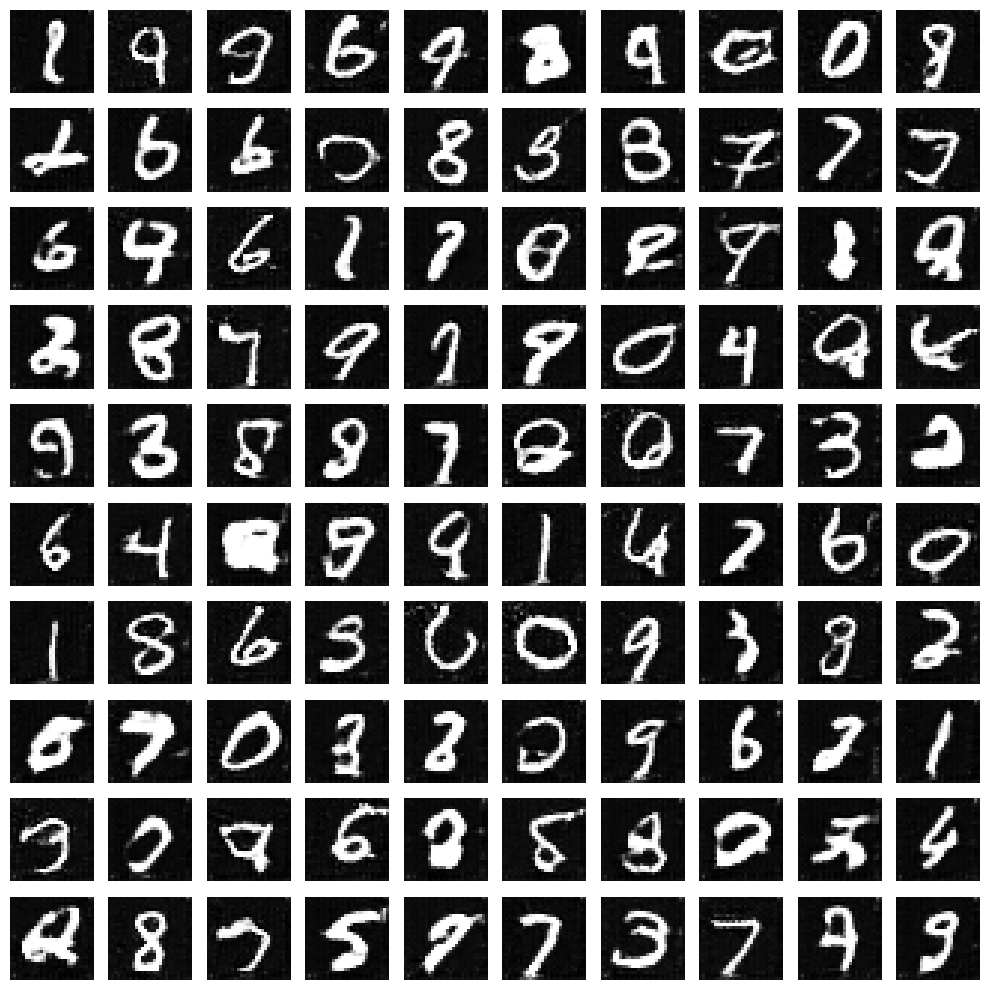

In [13]:
import matplotlib.pyplot as plt


sample = generate_sample(generator_state, generator_input)
sample = sample.reshape((-1, 28, 28))[:100]


fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for ax, image in zip(sum(axs.tolist(), []), sample):
    ax.imshow(image, cmap='gray', interpolation='nearest')
    ax.axis('off')
plt.tight_layout()
plt.show()
